# View on [nbviewer.jupyter.org](https://nbviewer.jupyter.org/github/icweaver/pyhat/blob/master/toymodel_gaussian.ipynb?flush_cache=true)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pymc3 as pm
import pandas as pd
import utils
import plotutils

C:\Users\tanve\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\tanve\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

# Standard normal example

$\newcommand{\rhat}{\widehat R}$
The following toy problem will help us demonstrate an improved diagnostic for MCMC convergence proposed by [Vehtari et al. (2019)](https://arxiv.org/pdf/1903.08008.pdf). This method uses the classic split-$\rhat$ metric, but in a novel way.

## Sample data

We'll start by creating some test data drawn from the standard normal distribution. This is what we will run our MCMC sampler on as a base case to highlight the problems with the current way split-$\rhat$ is used and methods to improve it suggested by the authors.

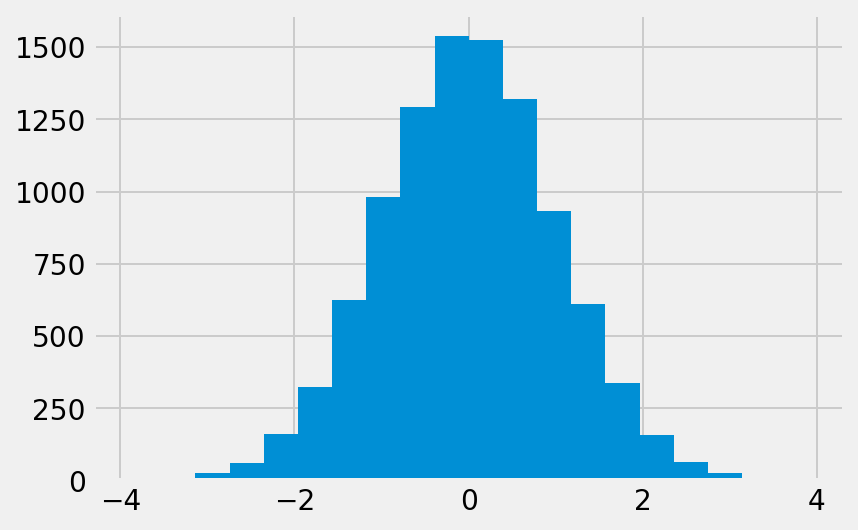

In [3]:
seed = 42
np.random.seed(seed)
data = np.random.normal(size=10_000)
plt.hist(data, bins=20)
plt.show()

## Run MCMC sampler

Let's now fit the data $y$ with the following model to be explored by our sampler:

$$
    \mu \sim \mathcal N(0, 1) \\
    y|\theta \sim \mathcal N(\mu, 1)
$$

In [4]:
params = ["mu"] # parameters to fit for
with pm.Model() as model:
    mu = pm.Normal(params[0], 0, 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=1.0, observed=data)

with model:
    trace = pm.sample(1_000, chains=4, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1984.58draws/s]


This model fits a normal curve with variance 1 and a single parameter $\theta$ that represents the mean $\mu$ and is given a standard normal prior. Below is a typical trace plot of the chains (right) and corresponding histogram (left) after the sampler has finished.

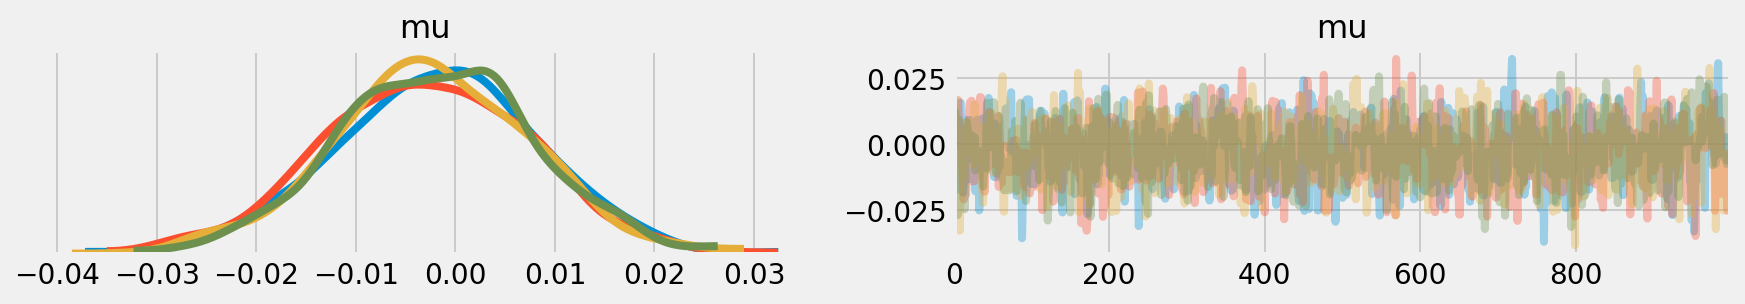

In [5]:
pm.traceplot(trace)
plt.show()

By eye the chains look to be converging. This statement is typically quantified by using the diagnostic metric:

$$
\rhat = \sqrt{\frac{\widehat{\text{var}}^+(\theta|y)}{W}},\quad
\widehat{\text{var}}^+(\theta|y) = \frac{N - 1}{N}W + \frac{1}{N}B,\quad
$$

where $\widehat{\text{var}}^+(\theta|y)$ is the marginal posterior variance of the parameters $\theta$ given the data $y$, $N$ is the number of samples in our MCMC chain, and $B$ and $W$ are the standard between- and within-chain variances defined in Equations 1 and 2 of the paper, respectively. A similar, but more robust diagnostic metric, split-$\rhat$ is calculated in the same way, except that the chains are first split in half, doubling $M$ and halving $N$. This has the added benefit of being sensitive to non-stationary chains. 

We can check if our implementation of $\rhat$ agrees with the one baked into the popular python package `pymc3`, which we also used as our sampler.

In [6]:
rhat = utils.rhat(trace, param=params[0], split=False)
rhat_pymc = pm.diagnostics.gelman_rubin(trace)[params[0]]

# compare our implemention to pymc3's
print(f"rhat_pymc:  {rhat_pymc}")
print(f"rhat:       {rhat}")

rhat_pymc:  1.0006222131931348
rhat:       1.0006222131931348


It looks like `pymc3` is using the standard definition for $\rhat$, which has since been outdated by the split-$\rhat$ method commonly used by packages like `stan`. Let's check that next.

In [7]:
rhat_split = utils.rhat(trace, param=params[0], split=True)

# compare split to previous un-split
print(f"rhat_split: {rhat_split}")
print(f"rhat:       {rhat}\n")
utils.print_percent_diff(rhat_split, rhat)

rhat_split: 1.0004776945816982
rhat:       1.0006222131931348

percent difference: 0.01%


We can see here that the split-$\rhat$ method can actually differ from the standard definition, even for a basic case like this. Let's test its robustness next by testing what happens if one of our chains happens to have a larger variance than the others.

# Increased variance example

We want to see that if we replace one of the chains of the original model with a fake model whether the traditional $\widehat{R}$ metric is able to understand this and whether the new metric can also understand this. Our fake model with have a variance of 4 now instead of 1:

In [8]:
with pm.Model() as model_fake:
    mu = pm.Normal(params[0], 0, 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=2.0, observed=data)

with model_fake:
    trace_fake = pm.sample(1_000, chains=2, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1535.17draws/s]


In [9]:
# extract trace array from pymc3's MultiTrace object
trace_dvar = np.array(trace.get_values(params[0], combine=False)) 
# replace first chain of trace array with the fake chain
trace_dvar[0, :] = np.array(trace_fake.get_values(params[0], combine=False))[0, :]


# compare to non-split example
rhat_split_dvar = utils.rhat(trace_dvar, split=True)
rhat_dvar = utils.rhat(trace_dvar, split=False)
print(f"rhat_dvar:       {rhat_dvar}")
print(f"rhat_split_dvar: {rhat_split_dvar}\n")
utils.print_percent_diff(rhat_split_dvar, rhat_dvar)

rhat_dvar:       1.0005062739852255
rhat_split_dvar: 1.000571547260054

percent difference: 0.01%


This fake injection does not affect the $\rhat$ metric, both split and traditional. Moreover, if we relied solely on the traceplot, we would also think that our chains have converged successfully.

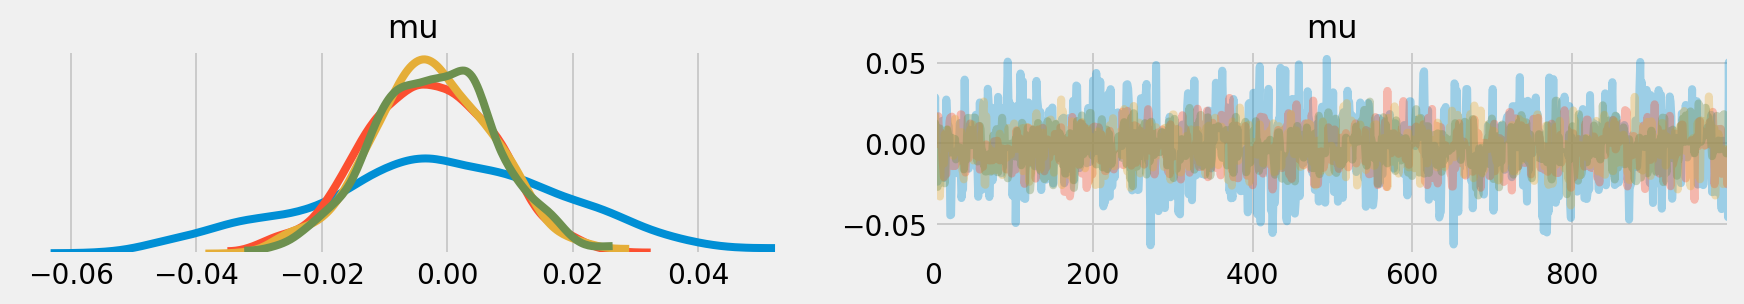

In [10]:
trace_dvar_dict = {params[0]:trace_dvar}
pm.traceplot(trace_dvar_dict)
plt.show()

This next example will show a method to further improve the reliability of split-$\rhat$ which can be sensitive to convergence issues like the one shown above.

# Rank normalized $\rhat$

This new method uses the same implementation of split-$\rhat$, but first transforms each chain before computing it. The transformation is given by Equation 6 in the text:

$$
z^{(nm)} = \Phi^{-1}\left[\frac{r^{(nm)} - 0.5}{S}\right] \quad,
$$

where $r^{(nm)}$ is the rank of $\theta^{(nm)}$, the $n$th parameter estimate of $N$ samples in the $m$th chain of $M$ total chains, and $S$ is the effective sample size estimate, and $\Phi^{-1}$ is the inverse normal transform.

First, we define function `zscale` that will project the traces into a standard Gaussian:

```python
def zscale(trace):
    S = len(trace.flatten())
    r = utils.rank(trace.flatten())
    z = sp.stats.norm.ppf((r - 0.5) / S).reshape(trace.shape)
    return z
```

We test `zscale` to make sure it is projecting everything to a Gaussian with $\mu = 0$ and $\sigma = 1$. 

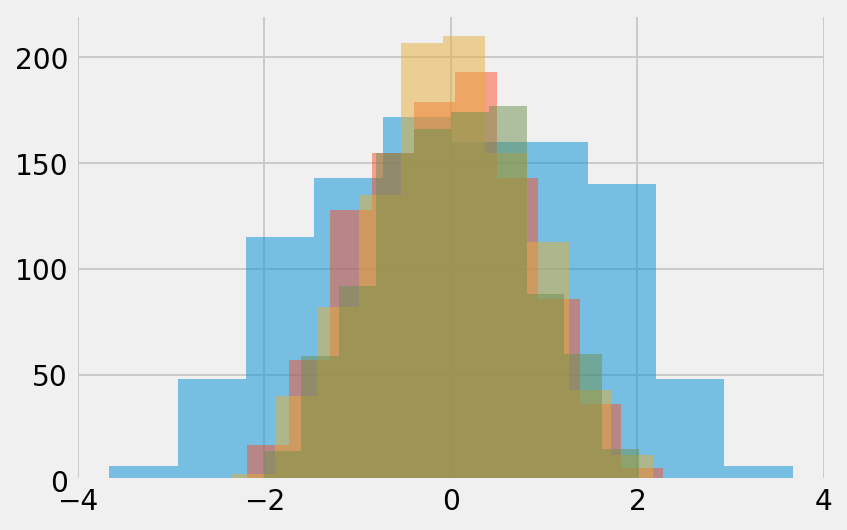

In [11]:
zscale_dvar = utils.zscale(trace_dvar)

for chain in zscale_dvar:
    plt.hist(chain, alpha = 0.5)

Now, we calculate the $\rhat$ metric called the *rank-normalized-split-*$\rhat$:

In [12]:
z_dvar = utils.zscale(trace_dvar)
rhat_split_dvar_rank = utils.rhat(z_dvar, split=True)

# compare to previous un-ranked example
print(f"rhat_split_dvar:       {rhat_split_dvar}")
print(f"rhat_split_dvar_rank:  {rhat_split_dvar_rank}\n")
utils.print_percent_diff(rhat_split_dvar_rank, rhat_split_dvar)

rhat_split_dvar:       1.000571547260054
rhat_split_dvar_rank:  1.0007411775765256

percent difference: 0.02%


This can still be fooled if the chains have the same location but different scales. The authors recommend computing the *rank-normalized-split-*$\rhat$ for the folded draws $\zeta^{nm}$. This is given by Equation 7 in the text:

$$
\zeta^{(nm)} = \left| \theta^{(nm)} - \text{median}(\theta) \right| \quad,
$$

and is termed the *folded-split* $\rhat$. This alternative ranked-normalized $\rhat$ is important because of its sensitivity to convergence in the tails of our chains. For this reason, the authors note that we should report the maximum between the *rank-normalized-split-*$\rhat$ and the *folded-split-*$\rhat$. when performing convergence diagnostics.

We implement the folded variant with `folded_split_rhat` and see the following results:

```python
def folded_split_rhat(trace, param):
    zeta = np.abs(trace - np.median(trace).reshape(-1, 1))
    zscale_folded = zscale(zeta)
    return utils.rhat(zscale_folded, param, split = True)
```

In [13]:
rhat_split_dvar_rank_folded = utils.folded_split_rhat(trace_dvar)

# compare to previous un-folded example
print(f"rhat_split_dvar_rank:        {rhat_split_dvar_rank}")
print(f"rhat_split_dvar_rank_folded: {rhat_split_dvar_rank_folded}\n")
utils.print_percent_diff(rhat_split_dvar_rank_folded, rhat_split_dvar_rank)

rhat_split_dvar_rank:        1.0007411775765256
rhat_split_dvar_rank_folded: 1.0644030880961817

percent difference: 6.36%


The *folded-split-*$\rhat$ does a much better job of detecting the non-converging chain, shown by the $\rhat$ value well above the conventional 1.01 convergence limit reported in the literature.

# $\rhat$ summary

Below, we copy the results from each method for easy comparison.

In [14]:
# regular vs. split rhat
print(f"rhat:                        {rhat}")
print(f"rhat_split:                  {rhat_split}\n")

# regular vs. split rhat on dvar chains
print(f"rhat_dvar:                   {rhat_dvar}")
print(f"rhat_split_dvar:             {rhat_split_dvar}\n")

# split-rank vs. split-rank-folded on dvar chains
print(f"rhat_split_dvar_rank:        {rhat_split_dvar_rank}")
print(f"rhat_split_dvar_rank_folded: {rhat_split_dvar_rank_folded}\n")

rhat:                        1.0006222131931348
rhat_split:                  1.0004776945816982

rhat_dvar:                   1.0005062739852255
rhat_split_dvar:             1.000571547260054

rhat_split_dvar_rank:        1.0007411775765256
rhat_split_dvar_rank_folded: 1.0644030880961817



# Rank plots

Now we show the rank plot to diagnose chains with `rankplot` .

```python
def rankplot(trace, nchains, rows, cols):
    """Returns rank plot for a given chain.
    Parameters
    ----------
    trace : numpy array of trace.
    nchains : number of chains to be plotted; nchains = rows * cols
    rows : number of rows in the plot
    cols: number of cols in the plot
    """
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(17, 10))
    gs = GridSpec(rows, cols)
    
    r = rank(trace.flatten()).reshape(trace.shape)
    
    for i in range(nchains):
        ax = fig.add_subplot(gs[i])
        plt.hist(r[i], alpha = 0.8, bins = 50, histtype = 'bar', ec='black')
        ax.set_title(f"Chain : {i + 1}")
```

First, we plot the regular chains:

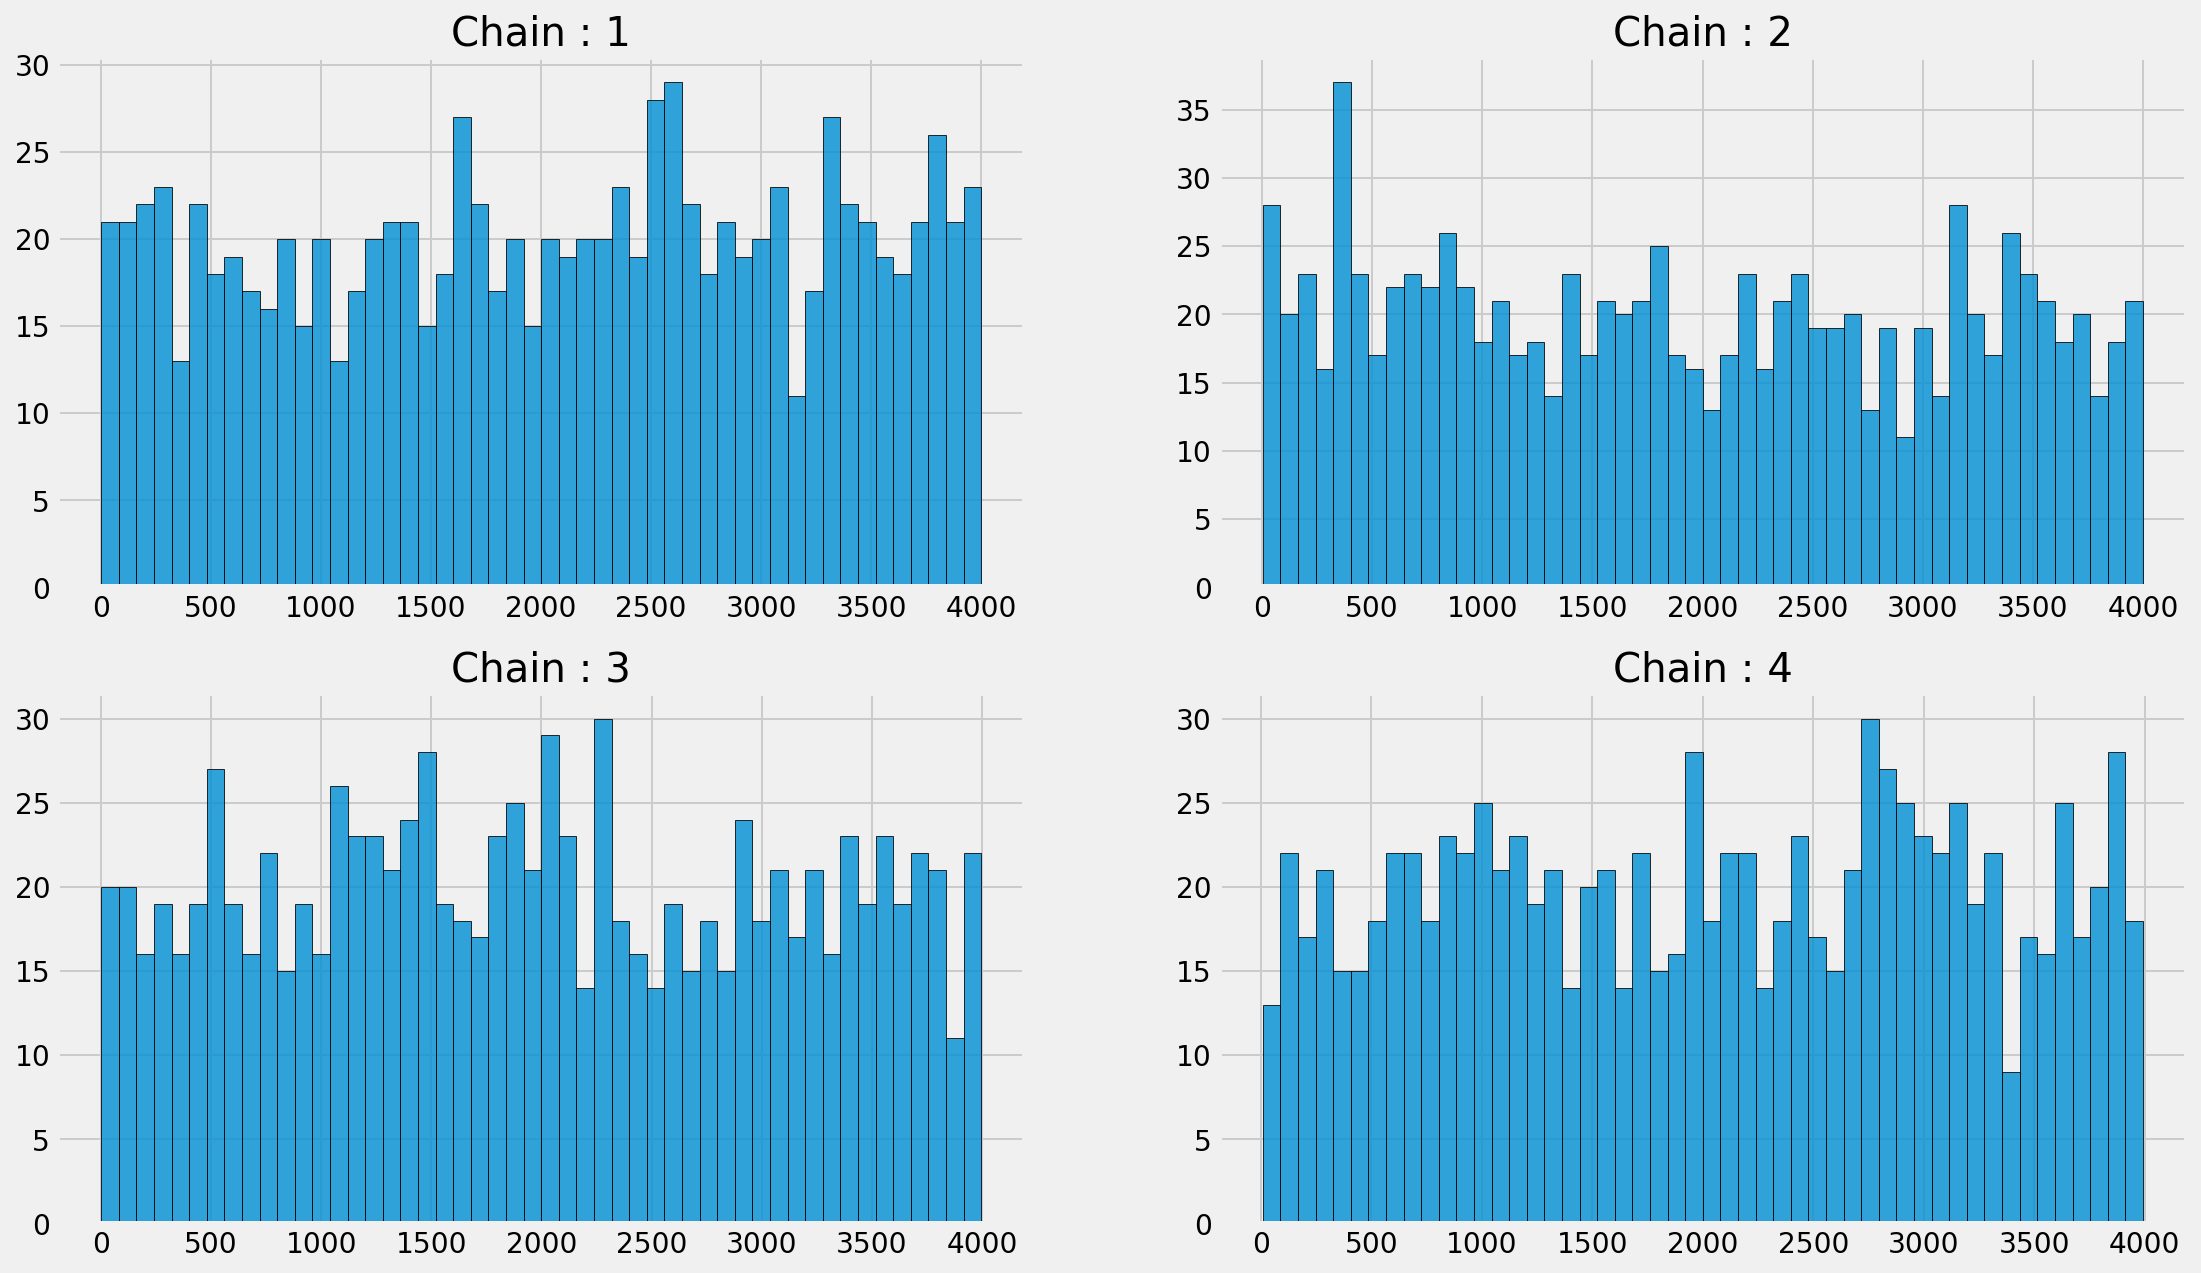

In [15]:
utils.rankplot(np.array(trace.get_values(params[0], combine=False)), 4, 2, 2)

Now, we plot the shifted chain example:

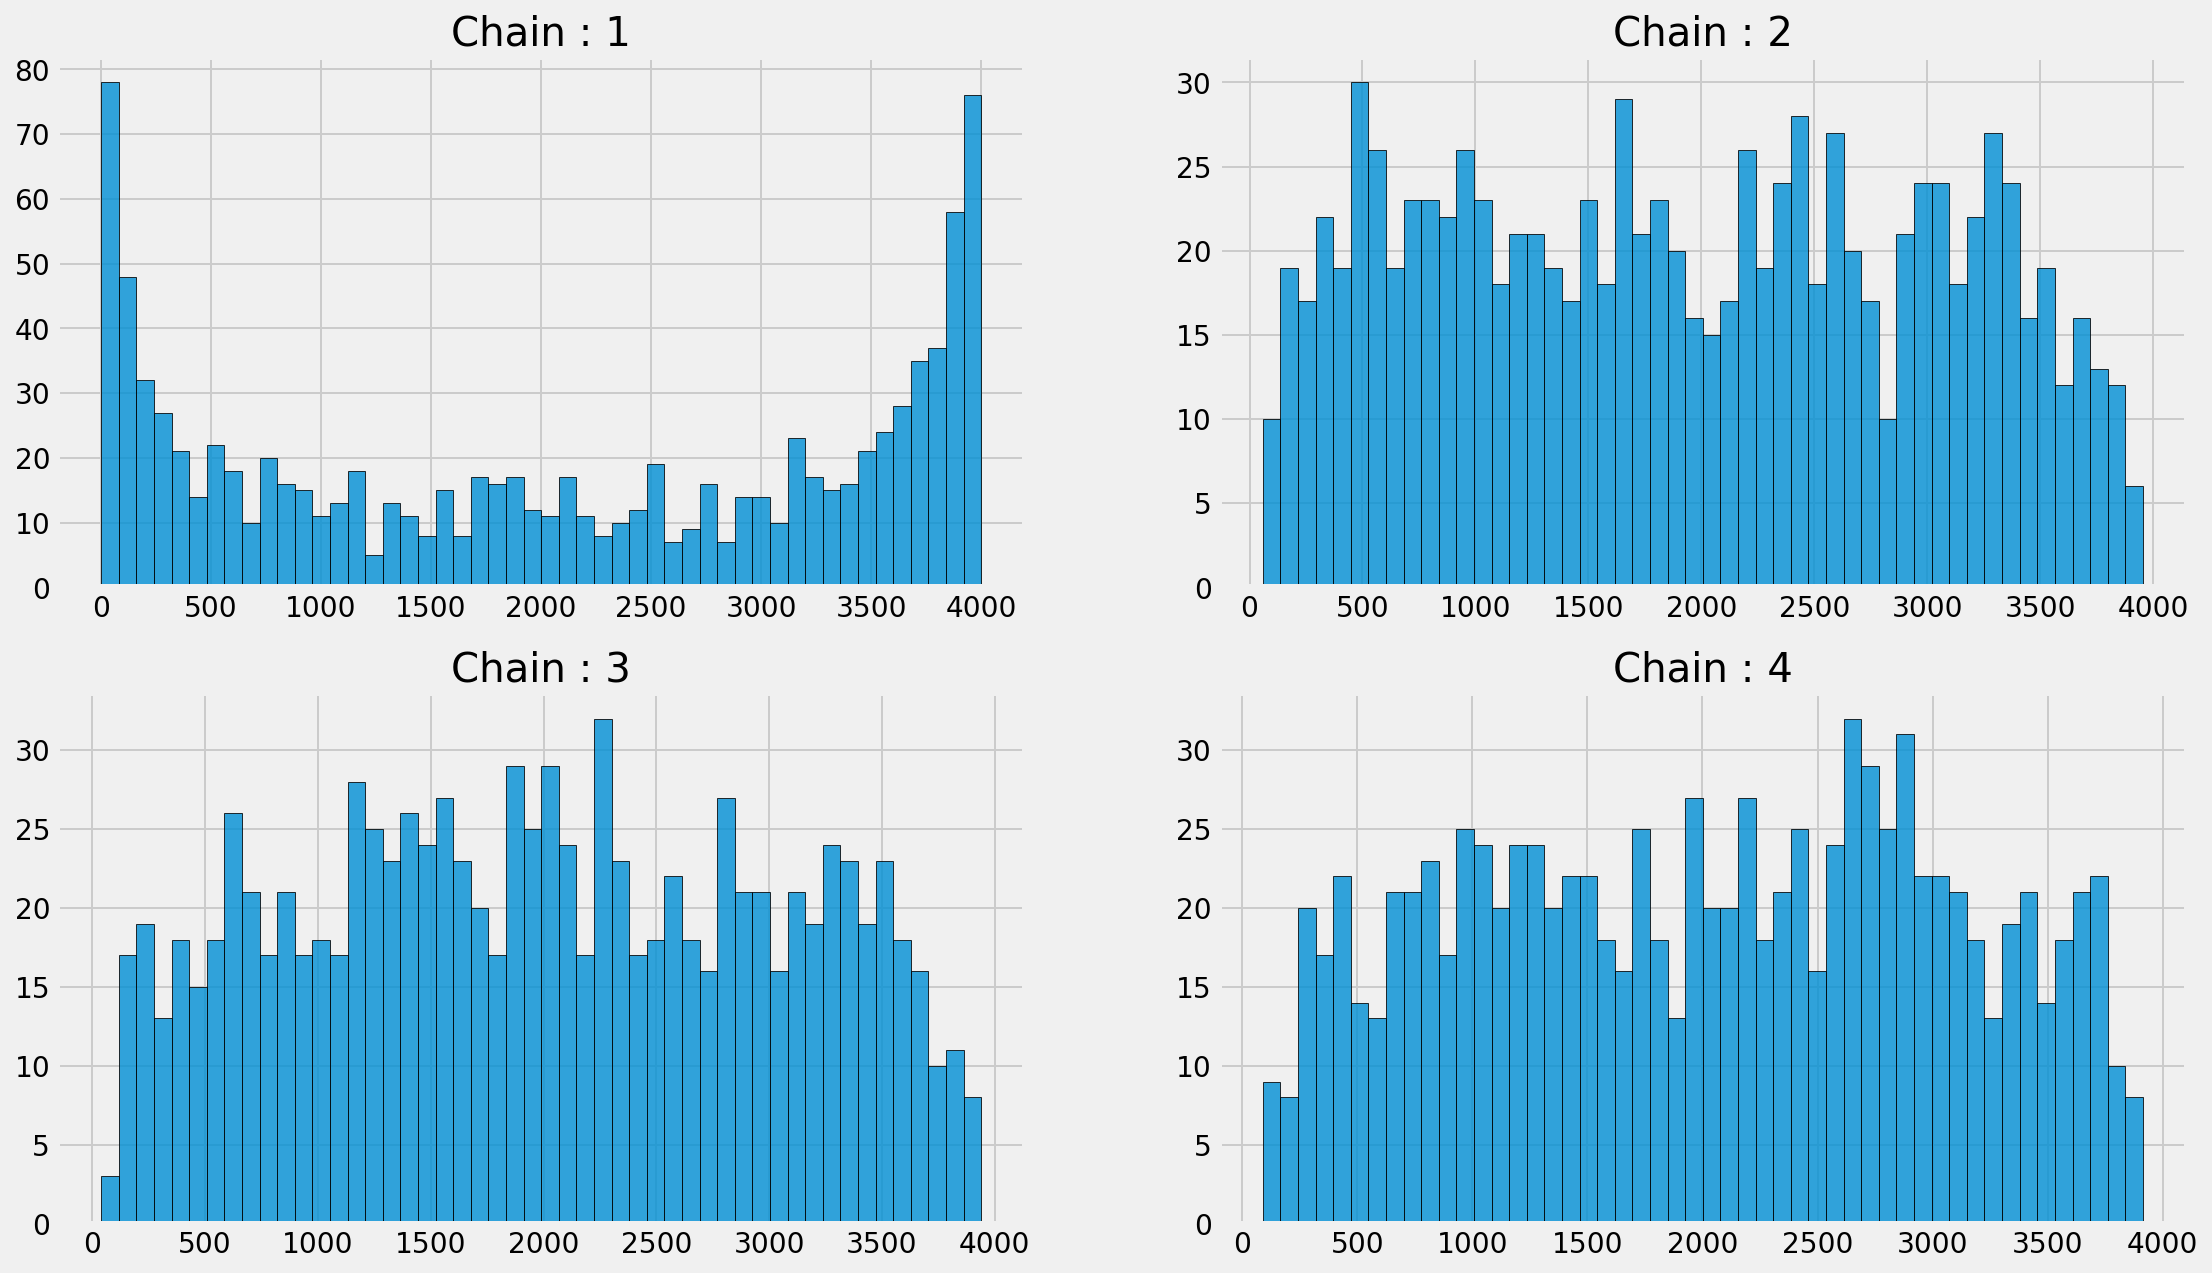

In [16]:
utils.rankplot(trace_dvar, 4, 2, 2)

Clearly as it is seen, something is not right with Chain $1$.